# Semantic Segment Road and Sidewalk
Tony Wang July 04 2023

After semantic segmentation of road and sidewalk, we obtain the pixel level binary mask of them. Which can be used to detect human-road relationship using rule-based comparision. Since the SAM didn't provide necessary api, I write some utility func to realize it

> This notebook is used for tutuorial demo, because I believe, compared to the unstable .py file, jupyter notebook would provide a vivid description and data pipeline demonstration.



## Library & Model Loading

In [43]:
import os
import cv2
# filter some annoying debug info
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import supervision as sv

import numpy as np
from PIL import Image
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
#TODO name!
from groundingdino.util.inference import load_model, load_image, predict, annotate

# import SAM_utility # 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to GroundingDINO and SAM checkpoints
GROUNDING_DINO_CONFIG_PATH = "../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "./weights/groundingdino_swint_ogc.pth"
MODEL_TYPE = "vit_b"
SAM_CHECKPOINT_PATH = "./weights/sam_vit_b_01ec64.pth"

# Predict classes and hyper-param for GroundingDINO
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25
PED_TRESHOLD = 0.5

NMS_THRESHOLD = 0.85
IOU_THRESHOLD = 0.5

In [44]:
DEBUG = False
# DEBUG = True


In [45]:

from depth_util import predict_depth,get_distance_category

from mask_util import (
    show_mask, show_points, show_box, display_mask, nms_processing, 
    is_overlap, compute_overlap, get_location, get_surface_info
)
from file_io    import is_image_file
from angle_util import describe_angle,estimate_angle

In [46]:
from DPT_module.dpt.models import DPTDepthModel
from DPT_module.dpt.midas_net import MidasNet_large
from DPT_module.dpt.transforms import Resize, NormalizeImage, PrepareForNet
import DPT_module.util.io as DPT_io
from torchvision.transforms import Compose

The model loading is quite long
with some unremovable warning in gDINO, just ignore it

In [47]:
# Initialize GroundingDINO model
grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH, 
    device=DEVICE
)

# Initialize SAM model and predictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


# Data structure
LocationInfo: pack form to help data-alignment

In [48]:
class LocationInfo:
    def __init__(self, object_type, id, box, mask,confidence):
        self.object_type = object_type  # ('sidewalk', 'road', or 'person')
        self.id = id  # Unique ID within the type
        self.box = box  # Bounding box in xyxy format
        self.mask = mask  # Binary mask indicating the precise location of the object
        self.confidence = confidence #confidence of bbox
        self.distance = None # str,{very close,close, median, far, very far}
        self.angle = None    # horizontal angle relative to camera
    def get_area(self):
        """
        int: The area of the object in pixels.
        """
        return np.sum(self.mask)
# class Scene:
#     def __init__(self):
#         self.location_info_list = []

#     def add_location_info(self, location_info):
#         self.location_info_list.append(location_info)

#     def remove_location_info(self, location_info):
#         self.location_info_list.remove(location_info)

#     def get_location_info(self, obj_type):
#         return [info for info in self.location_info_list if info.obj_type == obj_type]

#     def update_scene(self, new_location_info_list):
#         self.location_info_list = new_location_info_list

#     # Other methods can be added to manipulate and access the data as needed

## Utility Function


## Architecture:
1. gDINO : grounding_dino_model.predict_with_classes

   CLASSES_prompt= ['road', 'sidewalk']

   Based on testing, this pair is most reliable (otherwise the sidewalk may messed up with road) 

   In this part, I use the box as Region of Interest(ROI) to further prompt SAM

2. Non-maximum suppression (NMS) :

   get rid of redundant and overlapping bounding boxes.

   the metric is Intersection over Union(IoU)

3. Prompting SAM with ROI, select mask with largest area, in this step, the road and sidewalk can be segmented with naming in pixel level accuracy.

4. save the result 

5. label the result with label and confidence

6. TODO: do image sequence experiment, analyze the behavior of person

7. TODO: split cases based on JAAD info

   - car is moving 
   - car is stopping
   - time
   - weather
   - more...

In GTX3090 environment, the algorithm runs relatively fast with GPU boosting.

(Not as bad as I guessed before, much faster than all of the online demo)


## Location utility function
- is_overlap: a mask-level comparitor func

Surface Utility Function

In [49]:
def obj_print(obj_dict,image):
    for name, person in obj_dict.items():
        print(name)
        print(person.box)
        print(person.distance)
        person.angle = estimate_angle(image,person)

        print(f"angle is {person.angle},it is {describe_angle(person.angle)}")
        print("\n\n")



In [50]:
def write_to_txt(image_path, output_path, p_surface_overlaps, counts, labels, p_labels,obj_dict):
    """
    Writes the details of a road scene analysis into a text file. 
    The information includes:
    detected persons and the surfaces they are on, counts of various detections,
    labels for detections and people, and details about each object in the scene.
    

    Args:
        image_path (str): The relative path to the input image.
        output_path (str): The output path for the analysis results.
        p_surface_overlaps (List[Tuple[LocationInfo, List[LocationInfo]]])
        : A list of tuples where each tuple contains a person
        and a list of surfaces (as LocationInfo objects) that the person overlaps with.
        counts (Tuple[int, int, int, int]): A tuple containing counts of surface masks,
        road & sidewalk masks, people's masks, and actual people.
        labels (List[str]): A list of labels for the detected objects.
        p_labels (List[str]): A list of labels specifically for the detected persons.
        obj_dict (Dict[str, LocationInfo]) A dictionary mapping from unique entity identifiers 
        to corresponding LocationInfo objects.

    Returns & Raises:
        None
    """

    output_dir = Path(output_path).parent
    img_name = image_path[-8:-4]
    txt_name = "Info_Video_"+ str(output_dir)[-4:] +".txt"
    txt_path = os.path.join(output_dir, txt_name) 

    if DEBUG:
        print("output_dir: ", output_dir)
        print("image_name: ", img_name)
        print("txt_path: ", txt_path)
    # Check if file already exists
    if DEBUG:
        if os.path.exists(txt_path):
            # Read in existing data
            with open(txt_path, 'r') as f:
                existing_data = f.read()

            # If the info of the current image has already been recorded, return without appending
            if f"INFO of {img_name}:\n" in existing_data:
                print(f"ERROR: the info of{img_name} has been generated")
                return
    with open(txt_path, 'a') as f: # 'a' option is for appending to the file if it exists
        f.write(f"INFO of {img_name}:\n")

        get_surface_info(obj_dict,f)
        
        for person, surfaces in p_surface_overlaps:
            if surfaces:
                surface_str = ', '.join([f"{surface.object_type} {surface.id}" for surface in surfaces])
                f.write(f"Person {person.id} is on the {surface_str}\n")
            else:
                f.write(f"Person {person.id} is not on any detected surface\n")
                
        f.write(f"number of Surface mask, #Road&sidewalk, People 's mask, #detected people: {counts}\n")
        f.write(f"Labels: [{', '.join(labels)}]\n")
        f.write(f"Person Labels: [{', '.join(p_labels)}]\n\n")





## Key Function

In [51]:
def segment_ROI(sam_predictor: SamPredictor, image: np.ndarray, boxes: np.ndarray):
    # Prompting SAM with Region of Interest
    # Return: binary mask indicating the precise shape of object

    sam_predictor.set_image(image)
    result_masks = []
    for box in boxes:
        masks_np, iou_predictions, _ = sam_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=True,
        )
        #TODO Remove the following line to get all the person masks
        # index = np.argmax(scores_np) 
        # Add all masks to the result, not just the one with the highest score
        # Filter out masks with IoU scores below the threshold
        for mask, score in zip(masks_np, iou_predictions):
            if score >= IOU_THRESHOLD:
                result_masks.append(mask)

    return np.array(result_masks)



In [52]:
DEPTH_FLAG = False
def detect_road(image_path:str,output_path:str):
    """
        This function analyzes a road scene from an image and detects various
    entities such as roads, sidewalks, and people. 
    - detection: grounding DINO model
    - segmentation:     SAM model 
    - depth prediction: DPT model 
    Detected entities are represented as LocationInfo objects and stored in a Counter.
    The function also annotates the original image with detection boxes and labels.

    Args:
        image_path (str): Path to the input image.
        output_path (str): Path to save the output image with annotations and masks.

    Returns:
        obj_dict (dict): A dictionary mapping from unique entity identifiers 
        to corresponding LocationInfo objects.

    Raises:
        Exception: If the image at the given path cannot be read or processed.

    Note:
        global variables: BOX_TRESHOLD, TEXT_TRESHOLD, PED_TRESHOLD, and DEBUG,
        need to be set prior to calling this function.
    """

    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image at path {image_path} could not be loaded. Skipping.")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    except Exception as e:
        print(f"Failed to process image at {image_path}. Error: {e}")
        return None
    
    ROAD_SIDEWALK = ['road', 'sidewalk'] 
    P_CLASS     = ['person'] #,'bike']
    # the person label lower gDINO's performance
    # so I split them

    # detect road and sidewalk
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes = ROAD_SIDEWALK,
        box_threshold= BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = nms_processing(detections)
    # detect person 
    p_detections = grounding_dino_model.predict_with_classes(
        image = image,
        classes = P_CLASS , 
        box_threshold= BOX_TRESHOLD,
        text_threshold=PED_TRESHOLD - 0.3
    )
    p_detections = nms_processing(p_detections)

    box_annotator = sv.BoxAnnotator()
    person_annotator = sv.BoxAnnotator()

    labels = [
        f"{ROAD_SIDEWALK[class_id]} {i} {confidence:0.2f}" 
        for i, (_, _, confidence, class_id, _) in enumerate(detections)]

    P_labels = [
        f"{P_CLASS[class_id]} {i} {confidence:0.2f}" 
        for i, (_, _, confidence, class_id, _) in enumerate(p_detections)]

    DINO_boxes = np.array(detections.xyxy)
    P_boxes    = np.array(p_detections.xyxy)
    
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections ,labels=labels)
    if DEBUG:
        sv.plot_image(annotated_frame, (16, 16))
    person_annotation = person_annotator.annotate(scene=annotated_frame,detections= p_detections,labels= P_labels)
    if DEBUG:
        sv.plot_image(person_annotation, (16, 16))
    # cv2.imwrite("annotated_image.jpg", annotated_frame)
    
    SAM_masks = segment_ROI(sam_predictor,image,DINO_boxes)
    P_masks = segment_ROI(sam_predictor,image,DINO_boxes)

    # Create a list of LocationInfo objects for each detected object
    obj_dict = Counter()
    
    for i, (box, label, mask) in enumerate(zip(DINO_boxes, labels, SAM_masks)):
        object_type, id, confidence   = label.split(' ')
        index = object_type +id
        obj_dict[index] =  (LocationInfo(object_type, int(id), box, mask,confidence)) 

    for i, (box, label, mask) in enumerate(zip(P_boxes, P_labels, P_masks)):
        object_type, id, confidence = label.split(' ')
        index = object_type+id
        obj_dict[index] = (LocationInfo(object_type, int(id), box, mask,confidence)) 

    if DEPTH_FLAG:
        depth_map = predict_depth(image_path,output_path)
    
    # Analyze where each person is standing
    p_surface_overlaps = []
    
    for name, person in obj_dict.items():
        if person.object_type != "person":
            continue # We only want to analyze persons
        if DEPTH_FLAG:
            person.distance = get_distance_category(depth_map,person.mask)
            person.angle   = estimate_angle(image,person)
        
        overlaps = []
        for name, surface in obj_dict.items():
            # We only want to analyze surfaces (road or sidewalk)
            if surface.object_type not in ROAD_SIDEWALK: 
                continue

            # Check if the person and the surface overlap
            overlap, _ = is_overlap(person.mask, surface.mask)
            if overlap:
                overlaps.append(surface)

        p_surface_overlaps.append((person, overlaps))


    if DEBUG:
        # Print out the analysis results
        for person, surfaces in p_surface_overlaps:
            if surfaces:
                surface_str = ', '.join([f"{surface.object_type} {surface.id}" for surface in surfaces])
                print(f"Person {person.id} is on the {surface_str}")
            else:
                print(f"Person {person.id} is not on any detected surface")

    (i, j, k, d) = display_mask(SAM_masks,P_masks,P_boxes,DINO_boxes,person_annotation,output_path)
    

    write_to_txt(image_path, output_path, p_surface_overlaps, (i, j, k, d), labels, P_labels,obj_dict)

    plt.close()
    
    # return DINO_boxes,labels,P_labels,SAM_masks,P_masks
    return obj_dict

obj_dict= detect_road("input/scene_2.png",output_path="DINOmasked/scene_2.png")
# DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("input/video_0031/image_0005.png",output_path="DINOmasked/man.png")
# DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("JAAD_seg_by_sec/video_0268/image_0001.png",output_path="DINOmasked/video_0268/image_0001.png")
# DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("JAAD_seg_by_sec/video_0268/image_0003.png",output_path="DINOmasked/video_0268/image_0003.png")
# obj_dict,labels,p_labels =  detect_road("JAAD_seg_by_sec/video_0060/image_0005.png",output_path="SSS.png" )# "DINOmasked/video_0060/image_0005.png")
# obj_dict =  detect_road("input/S0710/image_0005.png",output_path="SSS.png" )# "DINOmasked/video_0060/image_0005.png")




refactored version


In [53]:
def get_cv2_image(image_path: str):
    """
    This function loads an image from a given path and converts it from BGR to RGB.

    Args:
    - image_path: The path to the image.

    Returns:
    - The converted image if successful, or None if the image could not be loaded or processed.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image at path {image_path} could not be loaded. Skipping.")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    except Exception as e:
        print(f"Failed to process image at {image_path}. Error: {e}")
        return None


In [54]:
def get_detections(image, box_threshold, text_threshold, classes):
    """
    This function runs the detection model and performs non-maximum suppression on the results.

    Args:
    - image: The input image.
    - box_threshold: The confidence threshold for considering detection boxes.
    - text_threshold: The confidence threshold for considering detected labels.
    - classes: The classes to detect.

    Returns:
    - detections: The detected objects after non-maximum suppression.
    """
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=classes,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    detections = nms_processing(detections)

    return detections

def get_label_and_box(classes,detections):
    
    labels = [
        f"{classes[class_id]} {i} {confidence:0.2f}" 
        for i, (_, _, confidence, class_id, _) in enumerate(detections)]
    boxes = np.array(detections.xyxy)
    return labels,boxes

def get_location_info(boxes, labels, masks):
    """
    This function creates LocationInfo objects for the detected objects.

    Args:
    - boxes: The detected objects.
    - labels: The labels for the detected objects.
    - masks: The segmentation masks for the detected objects.
    - object_type: The type of the objects.

    Returns:
    - obj_dict: A dictionary mapping from unique entity identifiers to corresponding LocationInfo objects.
    """
    obj_dict = dict()

    for i, (box, label, mask) in enumerate(zip(boxes, labels, masks)):
        object_type, id, confidence   = label.split(' ')
        index = object_type + id
        obj_dict[index] =  (LocationInfo(object_type, int(id), box, mask, confidence)) 

    return obj_dict

def analyze_person_location(obj_dict, depth_flag, image=None, depth_map=None):
    """
    This function analyzes where each person is standing.

    Args:
    - obj_dict: A dictionary of LocationInfo objects.
    - depth_flag: A flag indicating whether to predict the depth.
    - image: The input image.
    - depth_map: The depth map of the scene.

    Returns:
    - p_surface_overlaps: A list of tuples where each tuple contains a person and the surfaces they overlap with.
    """
    p_surface_overlaps = []
    
    for name, person in obj_dict.items():
        if person.object_type != "person":
            continue # We only want to analyze persons

        if depth_flag:
            person.distance = get_distance_category(depth_map,person.mask)
            person.angle   = estimate_angle(image,person)
        
        overlaps = []
        for name, surface in obj_dict.items():
            # We only want to analyze surfaces (road or sidewalk)
            if surface.object_type not in ['road', 'sidewalk']: 
                continue

            # Check if the person and the surface overlap
            overlap, _ = is_overlap(person.mask, surface.mask)
            if overlap:
                overlaps.append(surface)

        p_surface_overlaps.append((person, overlaps))

    return p_surface_overlaps


In [55]:
def get_annotated_image(image, labels,P_labels,detections,p_detections):

    box_annotator = sv.BoxAnnotator()
    person_annotator = sv.BoxAnnotator()

    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections ,labels=labels)
    if DEBUG:
        sv.plot_image(annotated_frame, (16, 9))
    person_annotation = person_annotator.annotate(scene=annotated_frame,detections= p_detections,labels= P_labels)
    if DEBUG:
        sv.plot_image(person_annotation, (16, 9))

    return person_annotation




In [57]:
def detect_road(image_path:str, output_path:str):
    image = get_cv2_image(image_path)
    ROAD_SIDEWALK = ['road', 'sidewalk'] 
    P_CLASS     = ['person'] #,'bike']
    # Detect objects
    detections = get_detections(image, BOX_TRESHOLD, TEXT_TRESHOLD,ROAD_SIDEWALK)
    p_detections = get_detections(image, BOX_TRESHOLD, PED_TRESHOLD - 0.3, P_CLASS)
    
    labels,DINO_boxes = get_label_and_box(ROAD_SIDEWALK,detections)
    P_labels, P_boxes = get_label_and_box(P_CLASS,p_detections)

    # Segment objects
    SAM_masks = segment_ROI(sam_predictor, image, DINO_boxes)
    P_masks = segment_ROI(sam_predictor, image, P_boxes)
    
    person_annotation = get_annotated_image(image, labels,P_labels,detections,p_detections)

    # Create LocationInfo objects
    obj_dict = get_location_info(DINO_boxes, labels, SAM_masks)
    obj_dict.update(get_location_info(P_boxes, P_labels, P_masks))


    num_obj = display_mask(SAM_masks,P_masks,P_boxes,DINO_boxes,person_annotation,output_path)

    return obj_dict, num_obj,labels, P_labels


    # Process and write results
def analyze_road(image_path,output_path, num_obj, labels, P_labels,depth_flag=False):

    image = get_cv2_image(image_path)
    depth_map = None
    # Predict depth
    if depth_flag:
        depth_map = predict_depth(image_path,output_path)

    # Analyze person location
    p_surface_overlaps = analyze_person_location(obj_dict, depth_flag, image, depth_map)

    if DEBUG:
        # Print out the analysis results
        for person, surfaces in p_surface_overlaps:
            if surfaces:
                surface_str = ', '.join([f"{surface.object_type} {surface.id}" for surface in surfaces])
                print(f"Person {person.id} is on the {surface_str}")
            else:
                print(f"Person {person.id} is not on any detected surface")

    i, j, k, d = num_obj 

    write_to_txt(image_path, output_path, p_surface_overlaps, (i, j, k, d), labels, P_labels,obj_dict)

    plt.close()

obj_dict, num_obj,labels, P_labels = detect_road("input/scene_2.png",output_path="DINOmasked/scene_2.png")
analyze_road("input/scene_2.png","DINOmasked/scene_2.png",obj_dict, num_obj,labels, P_labels)


Invalid distance description: medium
Invalid distance description: medium
Invalid distance description: medium
Invalid distance description: medium
Invalid distance description: medium


ValueError: too many values to unpack (expected 4)

## File IO logic
the following code demonstrate how is the IO logic organized

For the sake of fast file inquiry, I used library: Path() and os

Feel free to modify this part if you need, just in case the content is too big, which may crash the kernel

In [ ]:
image_path = "input/video_0268/image_0001.png"
output_path = "DINOmasked/video_0018/man.png"

output_dir = Path(output_path).parent

print(output_dir)
img_name = image_path[-8:-4]
txt_name = "Info_Video_"+ str(output_dir)[-4:] +".txt"
txt_path = os.path.join(output_dir, txt_name) 
print(txt_path)



DINOmasked/video_0018
DINOmasked/video_0018/Info_Video_0018.txt


In [ ]:
# STOP RUNNING THE MAIN PROGRAM

## Main Function

In [ ]:
input_dir = Path("input") # contain many folders  JAAD_seg_by_sec
output_dir = Path('DINOmasked')
output_dir.mkdir(parents=True, exist_ok=True)

print("===== Start =====")
i = 1
# Use rglob to recursively find all image files
for image_path in input_dir.rglob('*'):
    if is_image_file(str(image_path)):
        relative_path = image_path.relative_to(input_dir)

        output_path = output_dir / relative_path
        output_path.parent.mkdir(parents=True,exist_ok=True)

        if output_path.exists():
            print(f"Already scanned {output_path}, next one")
            continue
        else:
            print("Processing: ", i)
            i += 1
            print(f"Image path: {os.path.basename(str(image_path))}")

            result = detect_road(str(image_path),str(output_path))

            if result is not None:
                print(f"Detected: {image_path}") 
            else: 
                print( "failed to detect result")

print("===== END =====")
                


===== Start =====
Already scanned DINOmasked/man.png, next one
Already scanned DINOmasked/man_black.png, next one
Already scanned DINOmasked/scene_2.png, next one
Already scanned DINOmasked/scene_2_black.png, next one
Already scanned DINOmasked/S0710/image_0003.png, next one
Already scanned DINOmasked/S0710/image_0001.png, next one
Already scanned DINOmasked/S0710/image_0002.png, next one
Already scanned DINOmasked/S0710/image_0006.png, next one
Already scanned DINOmasked/S0710/image_0004.png, next one
Already scanned DINOmasked/S0710/image_0005.png, next one
Already scanned DINOmasked/S0710/image_0008.png, next one
Already scanned DINOmasked/S0710/image_0007.png, next one
Already scanned DINOmasked/S0710/image_0009.png, next one
Already scanned DINOmasked/S0710/image_0011.png, next one
Already scanned DINOmasked/S0710/image_0012.png, next one
Already scanned DINOmasked/S0710/image_0010.png, next one
Already scanned DINOmasked/S0710/image_0014.png, next one
Already scanned DINOmasked/S

In [ ]:
# input_dir  = Path("input")
# i = 0
# for image_path in input_dir.rglob('*'):
#     if i > 30: break
    
#     if is_image_file(str(image_path)):
#         i += 1

#         print("image path is" ,image_path)
#         relative_path = image_path.relative_to(input_dir)

#         output_filename = 'D_' + relative_path.name
        
#         output_path = Path(os.path.join( output_dir , output_filename))
#         print("output_path path is" ,output_path)
#         output_path.parent.mkdir(parents=True,exist_ok=True)


In [ ]:
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

def video_diff(result_old: dict, result_new: dict):
    """
    Compares two dictionaries of LocationInfo objects representing consecutive frames.
    For each object that appears in both frames, calculates the distance moved.

    Parameters:
    - result_old: A dictionary of LocationInfo objects from the previous frame.
    - result_new: A dictionary of LocationInfo objects from the current frame.

    Returns:
    - A dictionary mapping each object id to the distance it moved.
    """
    movement_dict = {}

    old_people = [obj for obj in result_old.values() if obj.object_type == 'person']
    new_people = [obj for obj in result_new.values() if obj.object_type == 'person']

    old_centroids = [[(obj.box[0] + obj.box[2]) / 2, (obj.box[1] + obj.box[3]) / 2] for obj in old_people]
    new_centroids = [[(obj.box[0] + obj.box[2]) / 2, (obj.box[1] + obj.box[3]) / 2] for obj in new_people]

    # calculate the distance matrix between all pairs of centroids
    dist_mat = distance_matrix(old_centroids, new_centroids)
    
    # apply the Hungarian algorithm to find the optimal assignment
    row_inds, col_inds = linear_sum_assignment(dist_mat)

    for row_ind, col_ind in zip(row_inds, col_inds):
        distance = dist_mat[row_ind, col_ind]
        # here we make a new key for each matched pair
        movement_dict[(old_people[row_ind].id, new_people[col_ind].id)] = distance

    return movement_dict


In [ ]:
def main(input_dir_path: str, output_dir_path: str):
    input_dir = Path(input_dir_path) 
    output_dir = Path(output_dir_path)
    output_dir.mkdir(parents=True, exist_ok=True)

    print("===== Start =====")
    image_paths = sorted(input_dir.rglob('*'), key=lambda x: x.stem)  # Use rglob to recursively find all image files and sort them
    
    # Check if there is at least one image in the directory
    if not image_paths:
        print(f"No images found in the directory {input_dir_path}")
        return

    result_old = None  # Initialize the variable for the first iteration

    for i, image_path in enumerate(image_paths, start=1):
        if is_image_file(str(image_path)):
            relative_path = image_path.relative_to(input_dir)

            output_path = output_dir / relative_path
            output_path.parent.mkdir(parents=True,exist_ok=True)

            # if output_path.exists():
            #     print(f"Already scanned {output_path}, moving to the next one")
            #     continue

            print(f"Processing image {i}: {os.path.basename(str(image_path))}")

            try:
                result_new = detect_road(str(image_path), str(output_path))
                if result_new is not None:
                    print(f"Detected objects in {image_path}")

                    # Compute and compare the speed only if there is a previous frame to compare with
                    if result_old is not None:
                        movedict = video_diff(result_old, result_new)
                        print(movedict)
                    result_old = result_new
                else: 
                    print(f"Failed to detect objects in {image_path}")

            except Exception as e:
                print(f"An error occurred while processing {image_path}: {e}")
                continue
    print("===== END =====")
    return movedict

movedict = main("Frame_3hz_ARHUD/video_0311/", "../speed")

===== Start =====
Processing image 1: image_0009.png
Detected objects in Frame_3hz_ARHUD/video_0311/image_0009.png
Processing image 2: image_0010.png
Detected objects in Frame_3hz_ARHUD/video_0311/image_0010.png
{(0, 1): 78.96284618903411, (1, 0): 156.8304924363512, (2, 2): 12.754288484468683, (3, 3): 3.347817057243743, (4, 5): 4.267570070045254, (5, 7): 2.283677361889471}
===== END =====


In [ ]:
movedict[(0,1)]

78.96284618903411

Detected objects in input/video_0045/image_0005.png
An error occurred while processing input/video_0045/image_0005.png: not enough values to unpack (expected 2, got 1)
Detected objects in input/video_0045/image_0005.png
An error occurred while processing input/video_0045/image_0005.png: not enough values to unpack (expected 2, got 1)
Detected objects in input/video_0045/image_0005.png
An error occurred while processing input/video_0045/image_0005.png: not enough values to unpack (expected 2, got 1)
Detected objects in input/video_0045/image_0005.png
An error occurred while processing input/video_0045/image_0005.png: not enough values to unpack (expected 2, got 1)
Detected objects in input/video_0045/image_0005.png
An error occurred while processing input/video_0045/image_0005.png: not enough values to unpack (expected 2, got 1)
Detected objects in input/video_0045/image_0005.png
An error occurred while processing input/video_0045/image_0005.png: not enough values to unpack (expected 2,

KeyboardInterrupt: 

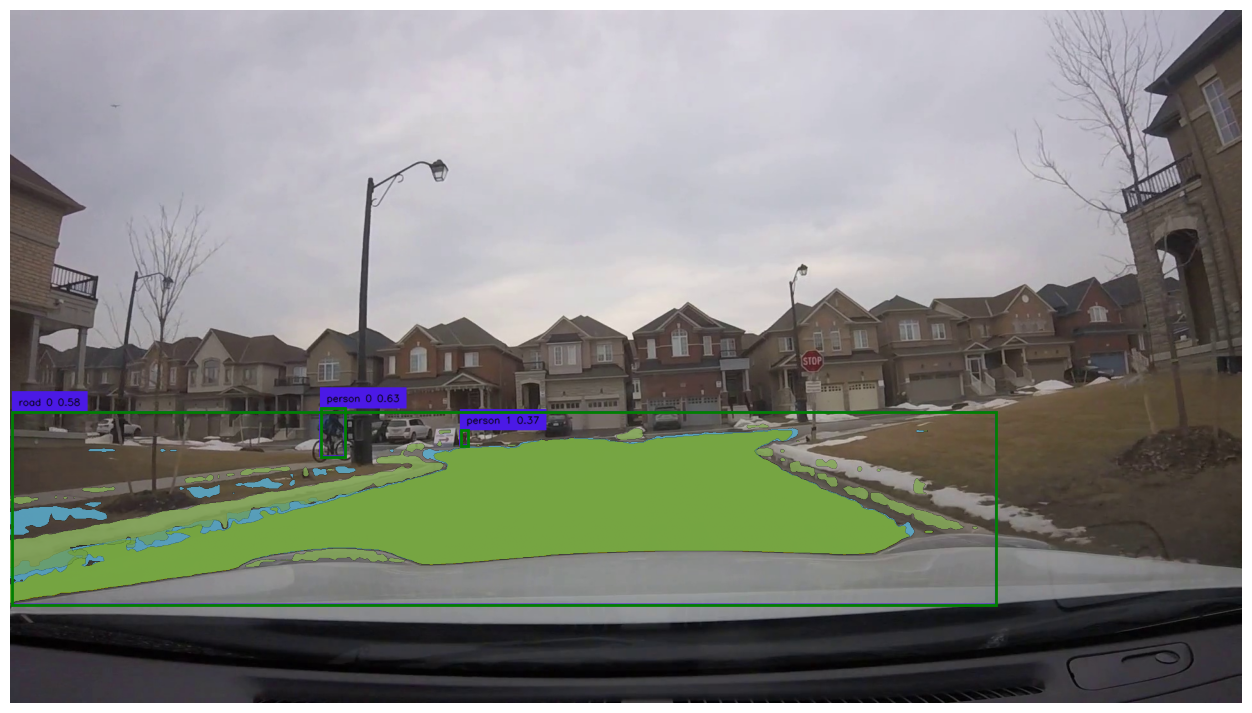

In [ ]:
import cv2

# Load your video
cap = cv2.VideoCapture('../dataset/JAAD/JAAD_clips/video_0060.mp4')

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # frames per second
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # width of the frames
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # height of the frames

# Define the codec and create a VideoWriter object to save processed video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # define the video codec
out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

# Check if video is opened
if not cap.isOpened():
    print("Error opening video")

# Initialize an empty dictionary for the 'old' result
result_old = {}

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()

    if ret:

        # Convert the frame to an image file (e.g., .jpg) if required by detect_road
        frame_path = "temporary_frame.jpg"
        cv2.imwrite(frame_path, frame)

        # Call your function here
        try:
            result_new = detect_road(str(frame_path), "temp_output.jpg")
            if result_new is not None:
                print(f"Detected objects in {image_path}")
                # Compute and compare the speed only if there is a previous frame to compare with
                if result_old is not None:
                    movedict = video_diff(result_old, result_new)
                    print(movedict)
                # Perform object tracking and update the result_old dictionary
                result_old = result_new
            else: 
                print(f"Failed to detect objects in {image_path}")
        except Exception as e:
            print(f"An error occurred while processing {image_path}: {e}")
            continue

        # Read the output frame for writing to video
        output_frame = cv2.imread("temp_output.jpg")

        # Write the processed frame to file
        out.write(output_frame)

    else:
        break

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()
